# Kickstarter Projects

## 目的
**プロジェクトのカテゴリや最終的に集めたい金額などからクラウドファンディングが成功するかどうかを予測する**

## Kaggle
https://www.kaggle.com/kemical/kickstarter-projects

# データセットの確認

## データの読み込み

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

/Users/suke/python_env/py3env/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# 分析用データとして ks-projects-201801.csv のみを用いる
data = pd.read_csv('./ks-projects-201801.csv' )

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 各列の説明

参考) : <br>
https://kickstarternavi.jp/tips/196/<br>

https://help.kickstarter.com/hc/ja/articles/115005028514-Kickstarter-%E3%81%AE%E5%9F%BA%E6%9C%AC%E3%81%A8%E3%81%AF%E3%81%AA%E3%82%93%E3%81%A7%E3%81%99%E3%81%8B-

| 列名 | 説明 |
|:-|:-|
|　ID　|　識別番号　|
| name | クラウドファンディングのプロジェクト名 |
| category | カテゴリー |
| main_category | おおまかなカテゴリー |
| currency | 支援に必要な通貨 |
| deadline | クラウドファンディングの締め切り日 |
| goal | 集めたい金額 |
| launched | クラウドファンディングの開始日時 |
| pledged | 最終的に集まった支援金額 |
| state | 成功したかどうか　(今回の目的変数) |
| backers | 支援者の人数 |
| country | 募集側の国名 |
| usd pledged | 最終的に集まった支援金額(USドル, Kickstarterが掲載している金額) |
| usd_pledged_real | 最終的に集まった支援金額(USドル, Fixer.io APIによって計算した金額) |
| usd_goal_real | 集めたい金額(USドル) |

今回は成功するかどうかを予測するモデルを作りたいので，目的変数は **state** である．<br>
また予測はクラウドファンディングの募集開始前に行うので，
- pledged
- backers
- usd pledged
- usd_pledged_real

は説明変数として用いないものとする．

さらに
- IDはただの識別番号であり，予測に使用できるものではない点
- nameにも多くの情報は含まれているが，一つ一つが異なり扱いが非常に難しい点

からID, nameについても説明変数としては用いないものとする．

In [3]:
# dataから説明変数として用いない変数を消去
data.drop(['ID', 'name', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'], axis=1, inplace=True)

data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


## 各列の代表値と欠損値

In [4]:
# 量的変数の代表値を表示
data.describe()

,goal,usd_goal_real
count,3.786610e+05,3.786610e+05
mean,4.908079e+04,4.545440e+04
std,1.183391e+06,1.152950e+06
min,1.000000e-02,1.000000e-02
25%,2.000000e+03,2.000000e+03
50%,5.200000e+03,5.500000e+03
75%,1.600000e+04,1.550000e+04
max,1.000000e+08,1.663614e+08


In [5]:
# データ数の確認
data.shape

(378661, 9)

goalとusd_goal_realの最小値が1ドルを切っている． $\rightarrow$ 異常値の可能性があるので要確認<br>
goalの平均額が第三四分位数よりも大きくなっている． $\rightarrow$ goalの分布は高額なものがかなり少ないと予想

In [6]:
# dataの欠損値確認
data.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

上記から今回用いるデータには欠損値がないことがわかるので，欠損値の補完は行わない．

# 変数の分布の可視化

## 目的変数の分布の可視化

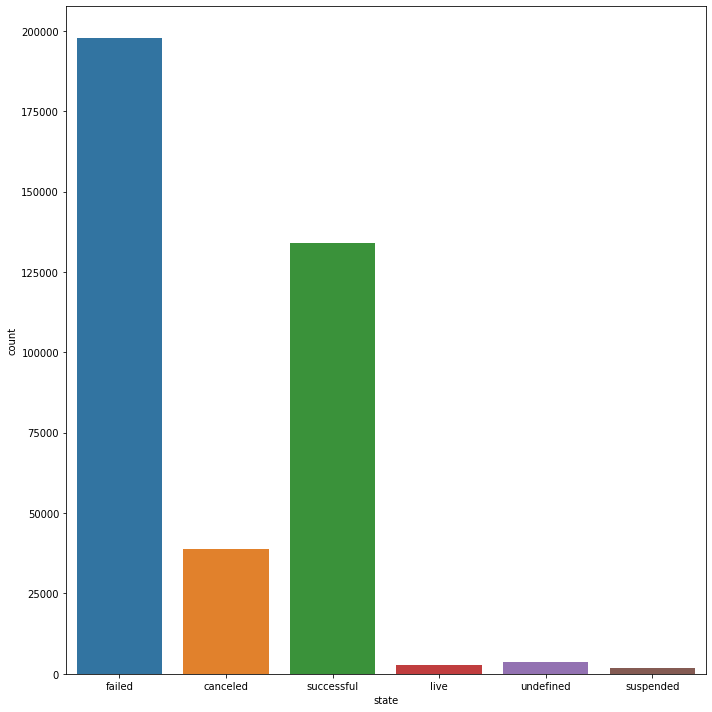

In [7]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

In [8]:
data['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [9]:
data_successful = data['state']=='successful'
print(f'クラウドファンディングの成功率 : {data_successful.sum() / data.shape[0]}')

クラウドファンディングの成功率 : 0.3537623362321443


In [10]:
data_failed = data['state']=='failed'
print(f'successful + failed : {(data_successful.sum() + data_failed.sum()) / data.shape[0]}')

successful + failed : 0.8759153966212523


クラウドファンディングの成功率は35.38%と，半分以上は成功していないことがわかる．<br>
またsuccessfulとfailedが全体の87.59%を占めていることがわかる．

## 説明変数の分布の可視化

### category

In [11]:
data['category'].value_counts()

Product Design     22314
Documentary        16139
Music              15727
Tabletop Games     14180
Shorts             12357
                   ...  
Residencies           69
Letterpress           49
Chiptune              35
Literary Spaces       27
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [12]:
print(set(data['category']))

{'Quilts', 'Food Trucks', 'Musical', 'Software', 'Fantasy', 'Public Art', 'Weaving', 'Design', 'Camera Equipment', 'Film & Video', 'Narrative Film', 'Zines', 'Jewelry', 'World Music', 'Spaces', 'Web', 'Architecture', 'Typography', 'Woodworking', 'Knitting', 'Textiles', 'Crafts', 'Product Design', 'Audio', 'Photography', 'Rock', 'Conceptual Art', "Farmer's Markets", 'Interactive Design', 'Art', 'Apparel', 'DIY', 'Small Batch', 'Immersive', 'Journalism', 'Comedy', 'Illustration', 'Thrillers', 'Science Fiction', 'Webseries', 'Workshops', 'Electronic Music', 'Robots', 'Animals', 'Mixed Media', 'Comics', '3D Printing', 'Sound', 'Anthologies', 'Jazz', 'Farms', 'Graphic Novels', 'DIY Electronics', 'Periodicals', 'Fine Art', 'Technology', 'Drama', 'Chiptune', 'People', 'Gadgets', 'Painting', 'Literary Spaces', 'Theater', 'Bacon', 'Family', 'Video', "Children's Books", 'Wearables', 'Food', 'Experimental', 'Video Games', 'Apps', 'Community Gardens', 'Action', 'Documentary', 'Horror', 'Crochet', 

categoryはmian_categoryをより詳しく分類したもので，159種類ある．

### main_category

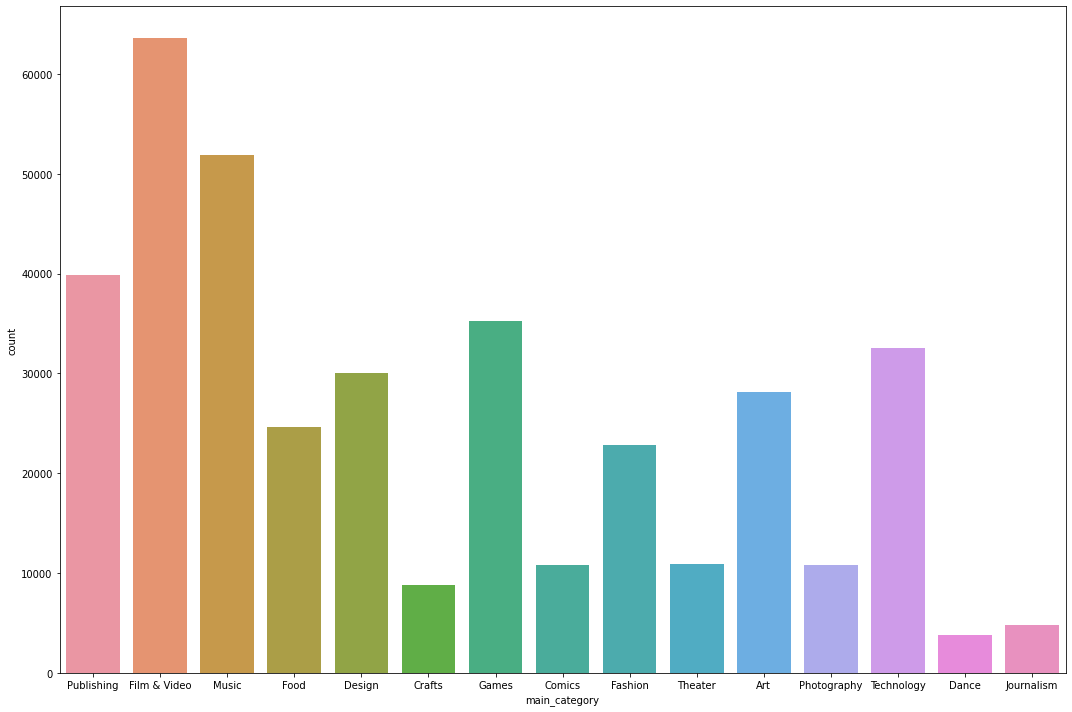

In [13]:
plt.figure(figsize=(15,10))
sns.countplot(x='main_category', data=data)
plt.tight_layout()

main_categoryは15種類存在し，
- Music, Theater, Danceはfailedよりもsuccessfulの方が多い
- Food, Technologyは他のカテゴリよりも成功率が低い
- Design, Gamesは他のカテゴリよりもcanceledの割合が高い

ということがわかる．

### currency

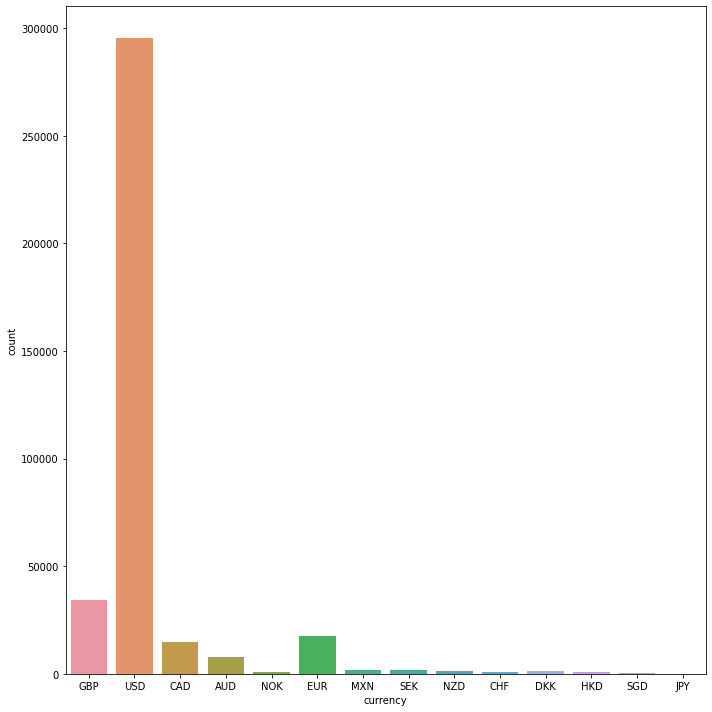

In [14]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

In [15]:
data['currency'].value_counts()

USD    295365
GBP     34132
EUR     17405
CAD     14962
AUD      7950
SEK      1788
MXN      1752
NZD      1475
DKK      1129
CHF       768
NOK       722
HKD       618
SGD       555
JPY        40
Name: currency, dtype: int64

In [16]:
data_USD = data['currency']=='USD'
print(f'USDの割合 : {data_USD.sum() / data.shape[0]}')

USDの割合 : 0.7800248771328444


In [17]:
data_GBP = data['currency']=='GBP'
data_EUR = data['currency']=='EUR'
data_CAD = data['currency']=='CAD'
data_AUD = data['currency']=='AUD'
print(f'USD, GBP, EUR, CAD, AUDが占める割合 : {(data_USD.sum() + data_GBP.sum() + data_EUR.sum() + data_CAD.sum() + data_AUD.sum()) / data.shape[0]}')

USD, GBP, EUR, CAD, AUDが占める割合 : 0.976636094026055


currencyの分布からクラウドファンディングで使用される通貨の78%はUSDであることがわかる．<br>
またUSD, GBP, EUR, CAD, AUDで全体の97.66%を占めている為，その他の通貨に関してはtheotherでまとめて扱っても問題ないだろう．

### country

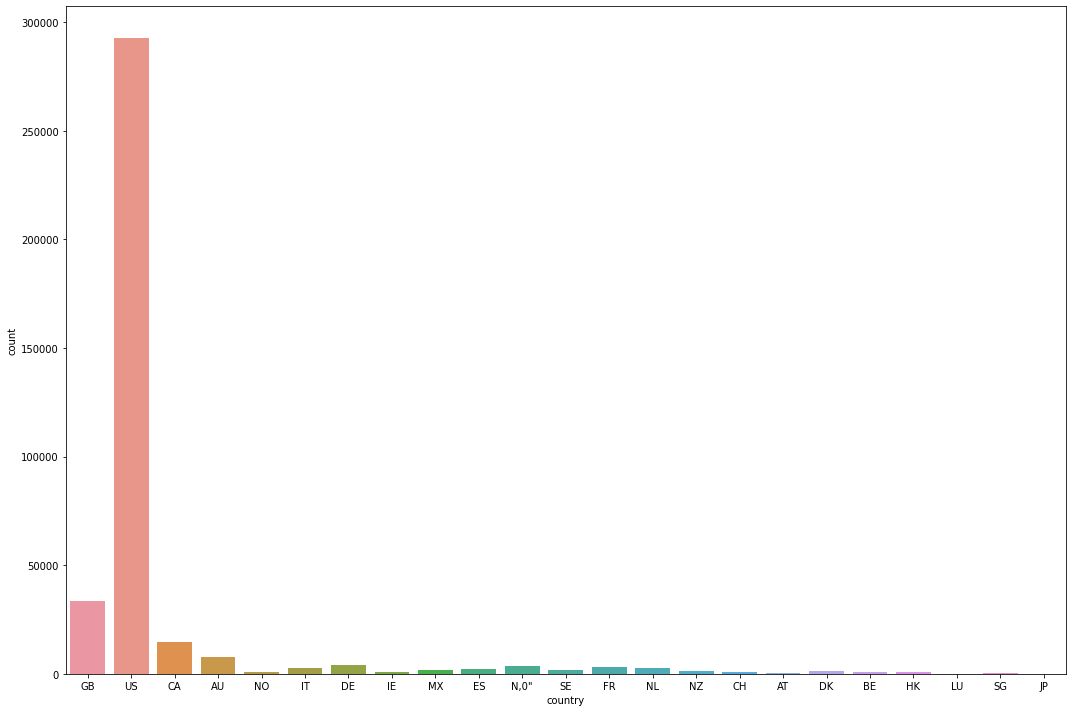

In [19]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()